In [1]:
import numpy as np
from numpy import genfromtxt
import scipy
from scipy.integrate import solve_bvp, solve_ivp, odeint
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()
import time
import ipywidgets
from ipywidgets import IntProgress, HBox, VBox, GridBox, Layout, Tab, FloatText, RadioButtons, Select
plt.rcParams.update({'figure.max_open_warning': 0})

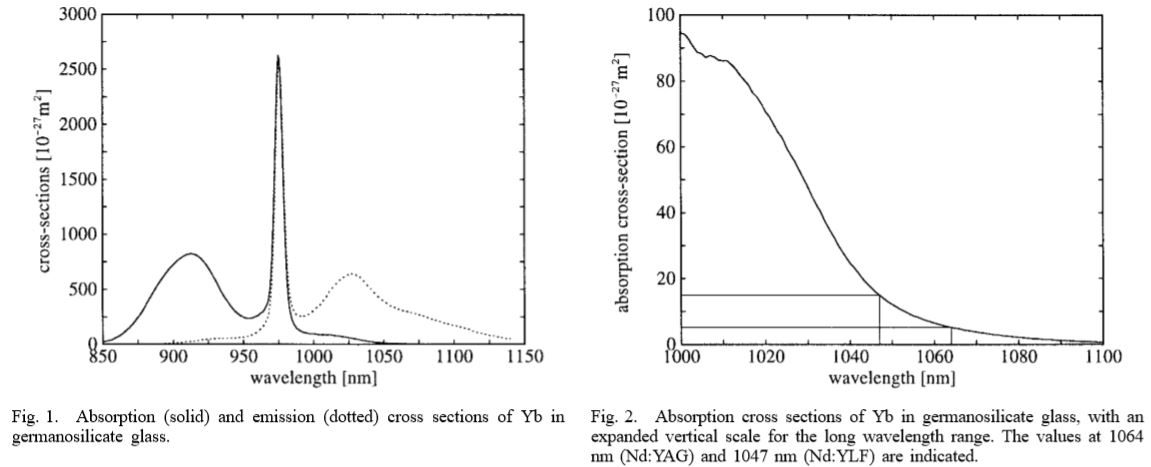

In [2]:
from IPython.core.display import Image 
Image(url='https://i.imgur.com/QOE7u9Y.jpg',embed=True,height=400, width=800)
# Image is from "Ytterbium-Doped Fiber Ampliﬁers," Rudiger Paschotta, Johan Nilsson, Anne C. Tropper, and David C. Hanna,
# IEEE JOURNAL OF QUANTUM ELECTRONICS, VOL. 33, NO. 7, JULY 1997

$\large\begin{array}{l}
{\alpha _k} = {\sigma _{a,k}}{\Gamma _k}{n_t}\\
{g_k} = {\sigma _{e,k}}{\Gamma _k}{n_t}\\
\frac{{{{\bar n}_2}}}{{{n_t}}} = \frac{{\sum\limits_k {\frac{{{P_k}\left( z \right)}}{{A_k^{eff}}}\frac{{{\alpha _k}\tau }}{{h{\nu _k}}}} }}{{1 + \sum\limits_k {\frac{{{P_k}\left( z \right)}}{{A_k^{eff}}}\frac{{\left( {{\alpha _k} + {g_k}} \right)\tau }}{{h{\nu _k}}}} }}\\
\frac{{d{P_k}}}{{dz}} = {\rm{s}}ig{n_k}\left( {{\alpha _k}\left( {\frac{{{{\bar n}_2}}}{{{n_t}}} - 1} \right) + {g_k}\frac{{{{\bar n}_2}}}{{{n_t}}} - \underbrace {{l_k}}_0} \right){P_k}\left( z \right) + {\rm{s}}ig{n_k}{g_k}\frac{{{{\bar n}_2}}}{{{n_t}}}mh{\nu _k}\Delta {\nu _k}\\
 + sig{n_k}\sum\limits_{k'} {g_{k,k'}^R\frac{{{P_{k'}}\left( z \right)}}{{A_{k'}^{eff}}}}  + {\mathop{\rm s}\nolimits} ig{n_k}\frac{{{P_{k'}}}}{{A_k^{eff}}}h{\nu _k}\Delta {\nu _k}
\end{array}$

In [3]:
# Parameters Determined by Fiber and Doping
gamma = 0.82 # Confinement factor for signals in core
sigmaa976 = 2600e-23 # Absorption cross-section for a Wavelenth of 976 nm in square cm
sigmae976 = 2600e-23 # Emission cross-section for a Wavelenth of 976 nm in square cm
sigmaa1030 =  47e-23 # Absorption cross-section for a Wavelenth of 1064 nm in square cm
sigmae1030 = 610e-23 # Emission cross-section for a wavelength of 1064 nm in square cm
sigmaa1064 = 5e-23 # Absorption cross-section for a wavelength of 1064 nm in square cm
sigmae1064 = 300e-23 # Emission cross-section for a Wavelenth of 1064 nm in square cm
sigmaa1122 = 1e-23 # Absorption cross-section for a wavelength of 1122 nm in square cm
sigmae1122 = 90e-23 # Emission cross-section for a Wavelenth of 1122 nm in square cm
tau = 0.84e-3 # Excited state lifetime in seconds

In [12]:
style = {'description_width': 'initial'}
rb=RadioButtons(
    options=['1064', '1030'],
    description='Signal Wavelength (nm):', style=style,)

slp=Select(
    options=['Core-Pumped', 'Cladding-Pumped'], height='',
    description='')
slp.layout.height='40px'; slp.layout.width='140px'

box_titles = ['Fiber Length (m)', 'Core Diameter (um)', 'Clad Diameter (um)',
'Pump Power (W)', 'Power Loss (db/m)', 'Signal (um)',
'Number of Interations']       
box_values = [1.5,5.5, 125,
1.0,400,0.001,
4]
box_steps = [0.1,0,1,5,
0.1,1,0.0001,
1]
items = [FloatText(value=box_values[i], description=box_titles[i], step=box_steps[i], style=style) for i in range (len(box_titles))]
for i in range (len(items)): items[i].layout.width='180px'
gb=GridBox(items, layout=Layout(grid_template_columns="repeat(3, 250px)"))
VBox([HBox([rb,slp]),gb])

<IPython.core.display.Javascript object>


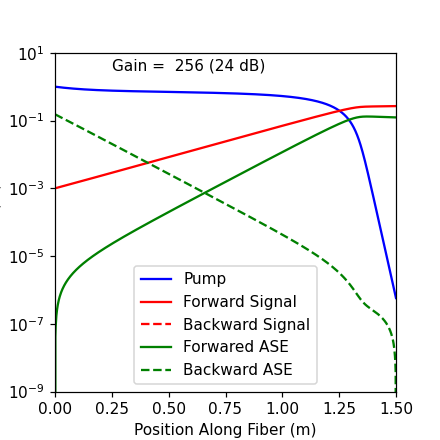

here


IntProgress(value=0, bar_style='success', description='Progress', max=7)

In [18]:
# Read In Widget Values
L = gb.children[0].value # Fiber length in m
coreD = gb.children[1].value*1e-4 # Core diameter in cm
cladD = gb.children[2].value*1e-4 # Core diameter in cm
p_power =gb.children[3].value # pump power in W
p_loss = gb.children[4].value/100/4.34 # pump loss in inverse cm
f_power = gb.children[5].value # average signal power in W
num_iter = int(gb.children[6].value) # number of numerical iterations used to ensure convergence
    
nt = p_loss/(sigmaa976)

# P[0]=CW Forward Pump
# P[1]=Fundamental
# P[2]= Backward Fundmanetal
# P[3]= Forward ASE
# P[4]= Backward ASE
num_signals=5

sign=np.zeros(num_signals)
sign[0]=1
sign[1]=1
sign[2]=-1
sign[3]=1
sign[4]=-1


g=np.zeros(num_signals)
alpha=np.zeros(num_signals)
l=np.zeros(num_signals)
# g[0]=sigmae976*gamma*nt*coreD**2/cladD**2
if rb.value == '1064':
    sigmae=sigmae1064; sigmaa=sigmaa1064
else:
    sigmae=sigmae1030; sigmaa=sigmaa1030
g[0]=sigmae976*gamma*nt
g[1]=sigmae*gamma*nt
g[2]=sigmae*gamma*nt
g[3]=sigmae1030*gamma*nt
g[4]=sigmae1030*gamma*nt

alpha[0]=sigmaa976*gamma*nt
alpha[1]=sigmaa*gamma*nt
alpha[2]=sigmaa*gamma*nt
alpha[3]=sigmaa1030*gamma*nt
alpha[4]=sigmaa1030*gamma*nt


Aeff=np.zeros(num_signals)
hnu=np.zeros(num_signals)
if slp == 'Core-Pumped':
    Aeff[0]=np.pi*(coreD/2)**2
else:
    Aeff[0]=np.pi*(cladD/2)**2
Aeff[0]=np.pi*(coreD/2)**2
Aeff[1]=np.pi*(coreD*gamma/2)**2
Aeff[2]=np.pi*(coreD*gamma/2)**2
Aeff[3]=np.pi*(coreD*gamma/2)**2
Aeff[4]=np.pi*(coreD*gamma/2)**2

hnu[0]=1239.42/976*1.6022e-19
hnu[1]=1239.42/float(rb.value)*1.6022e-19
hnu[2]=1239.42/float(rb.value)*1.6022e-19
hnu[3]=1239.42/1030*1.6022e-19
hnu[4]=1239.42/1030*1.6022e-19

deltanu=np.zeros(num_signals)
deltanu[3]=30/1030*3e8/1030e-9
deltanu[4]=30/1030*3e8/1030e-9
m=2 # Both polarizations of ASE are generated

def dPdz(Pd, zd):
    n2nta=0; n2ntb=0
    for k in range (num_signals):
        n2nta+=Pd[k]/Aeff[k]/nt*alpha[k]*tau/hnu[k]
        n2ntb+=Pd[k]/Aeff[k]/nt*(alpha[k]+g[k])*tau/hnu[k]
    n2=n2nta/(1+n2ntb)*nt
    n1=nt-n2
    dPdz = (sign*(alpha/nt*(-n1)+g*n2/nt)*Pd
                    + sign*g*n2/nt*m*hnu*deltanu)
    return dPdz

def frk45_step(Pd2, zd2, dz):
    dP1 = dz*dPdz(Pd2,z)
    dP2 = dz*dPdz(Pd2+dP1/2,zd2+dz/2)
    dP3 = dz*dPdz(Pd2+dP2/2,zd2+dz/2)
    dP4 = dz*dPdz(Pd2+dP3,zd2+dz/2)
    return (dP1+2*dP2+2*dP3+dP4)/6

def brk45_step(Pd3, zd3, dz):
    dP1 = dz*dPdz(Pd3,zd3)
    dP2 = dz*dPdz(Pd3+dP1/2,zd3+dz/2)
    dP3 = dz*dPdz(Pd3+dP2/2,zd3+dz/2)
    dP4 = dz*dPdz(Pd3+dP3,zd3+dz/2)
    return (dP1+2*dP2+2*dP3+dP4)/6

num_steps=1000
z = np.linspace(0,100*L,num_steps+1)
dz = 100*L/num_steps
P=np.zeros([num_signals,num_steps+1])
Ptemp=P
P0=[p_power,f_power,0,0,0.01]
P[:,0]=P0
P[4,:]=0.01

for i in range (num_steps):
    for k in [0,1,3]:
        P[k,i+1]=frk45_step(P[:,i],z[i],dz)[k]+P[k,i]
Ptemp=P
pump=P[0,:]
fundamental=P[1,:]
backward_fund=P[2,:]
fASE=P[3,:]
bASE=P[4,:]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
# fig.canvas.layout.width = '700px'
# fig.canvas.header_visible = False
plt.xlim(0,L)
plt.ylim(1e-9,10*p_power)
line0, = ax.semilogy(z/100,pump,label='Pump',color='blue')
line1, = ax.semilogy(z/100,fundamental,label='Forward Signal',color='red')
line2, = ax.semilogy(z/100,backward_fund,'--',label='Backward Signal',color='red')
line3, = ax.semilogy(z/100,fASE,label='Forwared ASE',color='green')
line4, = ax.semilogy(z/100,bASE,'--',label='Backward ASE',color='green')
plt.legend(handles=[line0,line1,line2,line3,line4])
plt.xlabel('Position Along Fiber (m)')
plt.ylabel('Power (W)')
fig.canvas.draw()
time.sleep(0.1)

def replot():
    line0.set_data(z/100, P[0,:])
    line1.set_data(z/100, P[1,:])
    line2.set_data(z/100, P[2,:])
    line3.set_data(z/100, P[3,:])
    line4.set_data(z/100, P[4,:])
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.1)

P[4,-1]=0
for i in range (num_steps):
    for k in [4]:
        P[k,num_steps-i-1]=brk45_step(P[:,num_steps-i],z[num_steps-i],-dz)[k]+P[k,num_steps-i]  
replot()
print ('here')

prog = IntProgress(min=0, max=num_iter-1, description='Progress', bar_style='success')
display(prog)
for j in range(num_iter):
    for i in range (num_steps):
        for k in [0,1,3]:
            Ptemp[k,i+1]=frk45_step(Ptemp[:,i],z[i],dz)[k]+Ptemp[k,i]   
    P=np.less(P,Ptemp)*(-1.0)*np.minimum(np.absolute(P-Ptemp), np.absolute(0.1*Ptemp))+P
    P=np.greater_equal(P,Ptemp)*np.minimum(np.absolute(P-Ptemp), np.absolute(10.0*Ptemp))+P
    Ptemp=P
    replot()
    
    for i in range (num_steps):
        for k in [4]:
            Ptemp[k,num_steps-i-1]=brk45_step(P[:,num_steps-i],z[num_steps-i],-dz)[k]+Ptemp[k,num_steps-i]
    P=np.less(P,Ptemp)*(-1.0)*np.minimum(np.absolute(P-Ptemp), np.absolute(0.1*Ptemp))+P
    P=np.greater_equal(P,Ptemp)*np.minimum(np.absolute(P-Ptemp), np.absolute(10.0*Ptemp))+P
    P=Ptemp
    replot()
    prog.value=j
Gain = fundamental[-1]/f_power
gain_text=ax.text(x=0.25,y=3,s='Gain = '+ '{:4.0f}'.format(Gain) + ' (' + '{:2.0f}'.format(np.log10(Gain)*10) +' dB)')
fig.canvas.draw()